In [1]:
import scipy.io as scio
import h5py
import tifffile as tf
from PIL import Image

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import networkx as nx
from networkx.algorithms import community
import powerlaw

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import entropy
from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import wilcoxon
from itertools import chain
from statsmodels.stats.multitest import multipletests

## Settings and Parameters

In [5]:
region_names = {64: 'MBPED',65: 'MBVL',66: 'MBML',55: 'LH',72: 'SLP',73: 'SIP',74: 'SMP',63: 'CRE',84: 'SCL',59: 'ICL',
                4: 'NO',23: 'EB',26: 'FB',56: 'LAL',79: 'AOTU',75: 'AVLP',76: 'PVLP',77: 'IVLP',60: 'VES',80: 'GOR',82: 'SPS',
                85: 'EPA',67: 'FLA'}
focus_regions_0 = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]

## path
path_local ="xxxx/data_analysis_res_revision/temporal_res/"
path_inspur = "xxxx/olfactory_representation/"
print("path_local:", path_local)
print("path_inspur:", path_inspur)

path_local: xxxx/data_analysis_res_revision/temporal_res/
path_inspur: xxxx/olfactory_representation/


## Figure 5-g

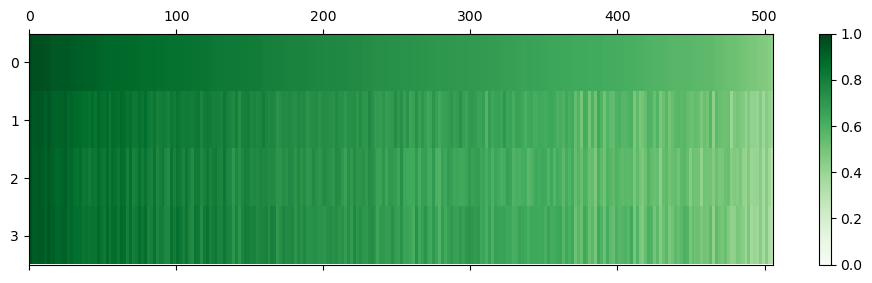

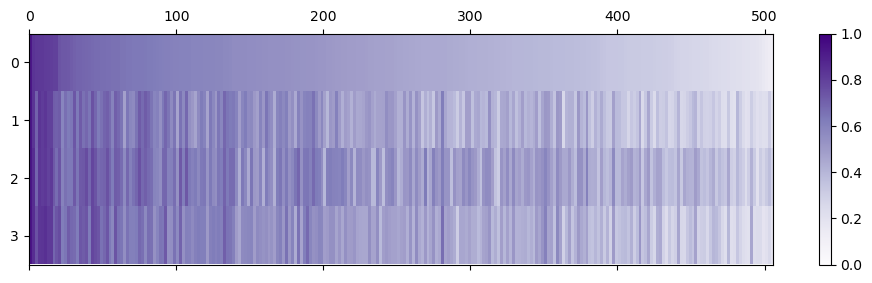

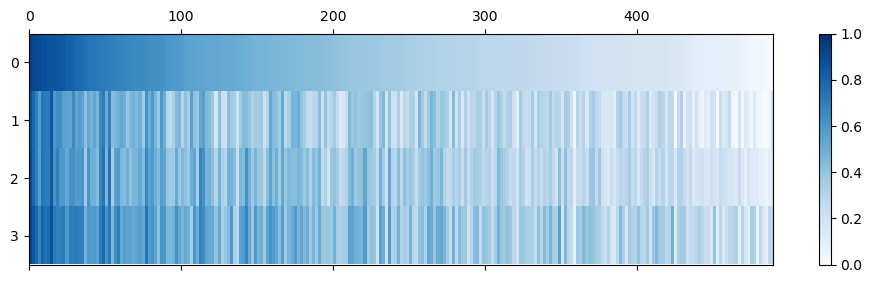

In [3]:
'''
G7f correlation
'''

## G7f
calc_path = path_inspur + 'G7f_average_Stim\\'
calc_all = []
for per in range(4):
    data_df = np.load(calc_path + "whole_brain_all_regions_similarity_ACH_5HT_preiod" + str(per) + ".npy", allow_pickle = True)
    calc_all.append(data_df.flatten())         
sorted_index = sorted(range(len(calc_all[0])), key = lambda k : calc_all[0][k], reverse = True)
cut = 0
for i in range(len(sorted_index)):
    idx = sorted_index[i]
    if calc_all[0][idx] == 0:
        cut = i
        break
calc_all_new = []
for per in range(4):
    new = [calc_all[per][i] for i in sorted_index[:cut]]
    calc_all_new.append(new)

## plot
figure = plt.figure(figsize=(12,3)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(calc_all_new, interpolation ='nearest', cmap = "Greens",aspect = 'auto', vmin = 0, vmax = 1) 
figure.colorbar(caxes)
plt.savefig(path_local + 'period_similarity_matshow_calc.pdf', dpi = 300, bbox_inches='tight')
plt.show()

'''
ACh correlation
'''

## ACh
calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
calc_all = []
for per in range(4):
    data_df = np.load(calc_path + "whole_brain_all_regions_similarity_ACH_preiod" + str(per) + ".npy", allow_pickle = True)
    calc_all.append(data_df.flatten())        
sorted_index = sorted(range(len(calc_all[0])), key = lambda k : calc_all[0][k], reverse = True)
cut = 0
for i in range(len(sorted_index)):
    idx = sorted_index[i]
    if calc_all[0][idx] == 0:
        cut = i
        break
calc_all_new = []
for per in range(4):
    new = [calc_all[per][i] for i in sorted_index[:cut]]
    calc_all_new.append(new)

## plot
figure = plt.figure(figsize=(12,3)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(calc_all_new, interpolation ='nearest', cmap = "Purples",aspect = 'auto', vmin = 0, vmax = 1)  
figure.colorbar(caxes)
plt.savefig(path_local + 'period_similarity_matshow_ach.pdf', dpi = 300, bbox_inches='tight')
plt.show()

'''
5HT correlation
'''

## 5HT
calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
calc_all = []
for per in range(4):
    data_df = np.load(calc_path + "whole_brain_all_regions_similarity_5HT_preiod" + str(per) + ".npy", allow_pickle = True)
    calc_all.append(data_df.flatten())                
sorted_index = sorted(range(len(calc_all[0])), key = lambda k : calc_all[0][k], reverse = True)
cut = 0
for i in range(len(sorted_index)):
    idx = sorted_index[i]
    if calc_all[0][idx] == 0:
        cut = i
        break
calc_all_new = []
for per in range(4):
    new = [calc_all[per][i] for i in sorted_index[:cut]]
    calc_all_new.append(new)

## plot
figure = plt.figure(figsize=(12,3)) 
axes = figure.add_subplot(111) 
caxes = axes.matshow(calc_all_new, interpolation ='nearest', cmap = "Blues",aspect = 'auto', vmin = 0, vmax = 1) 
figure.colorbar(caxes)
plt.savefig(path_local + 'period_similarity_matshow_5ht.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [4]:
'''
Define the Scheirer–Ray–Hare test

The Scheirer–Ray–Hare test is a non-parameter alternative to multi-factorial ANOVA analyse.
'''

def SRH(region_pairs, stages, measure):
    data_dict = {"Pairs": region_pairs, "Stages": stages, "Measure": measure}
    data = pd.DataFrame.from_dict(data_dict)

    # Calculating the ranks
    data['rank'] = data.Measure.sort_values().rank(numeric_only = float)

    # Calculating the sum of the squares
    rows = data.groupby(['Pairs'], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'row'})
    rows.columns = ['_'.join(col) for col in rows.columns]
    rows.columns = rows.columns.str.replace(r'_$',"", regex = True)
    rows['row_mean_rows'] = rows.row_mean.mean()
    rows['sqdev'] = (rows.row_mean - rows.row_mean_rows)**2

    cols = data.groupby(['Stages'], as_index = False).agg({'rank':['count', 'mean', 'var']}).rename(columns={'rank':'col'})
    cols.columns = ['_'.join(col) for col in cols.columns]
    cols.columns = cols.columns.str.replace(r'_$',"", regex = True)
    cols['col_mean_cols'] = cols.col_mean.mean()
    cols['sqdev'] = (cols.col_mean-cols.col_mean_cols)**2

    data_sum         = data.groupby(['Pairs', 'Stages'], as_index = False).agg({'rank':['count', 'mean', 'var']})
    data_sum.columns = ['_'.join(col) for col in data_sum.columns]
    data_sum.columns = data_sum.columns.str.replace(r'_$',"", regex = True)

    nobs_row   = rows.row_count.mean()
    nobs_total = rows.row_count.sum()
    nobs_col   = cols.col_count.mean()

    Columns_SS = cols.sqdev.sum()*nobs_col
    Rows_SS    = rows.sqdev.sum()*nobs_row
    Within_SS  = data_sum.rank_var.sum()*(data_sum.rank_count.min()-1)
    MS         = data['rank'].var()
    TOTAL_SS   = MS * (nobs_total-1)
    Inter_SS   = TOTAL_SS - Within_SS - Rows_SS - Columns_SS

    # Calculating the H-statistics and degrees of freedom
    H_rows = Rows_SS/MS
    H_cols = Columns_SS/MS
    H_int  = Inter_SS/MS

    df_rows   = len(rows)-1
    df_cols   = len(cols)-1
    df_int    = df_rows*df_cols
    df_total  = len(data)-1
    df_within = df_total - df_int - df_cols - df_rows

    # Calculating the p-values
    p_rows  = round(1-stats.chi2.cdf(H_rows, df_rows),4)
    p_cols  = round(1-stats.chi2.cdf(H_cols, df_cols),4)
    p_inter = round(1-stats.chi2.cdf(H_int, df_int),4)

    print("Scheirer–Ray–Hare test p-value:", p_cols) # p-value for the given stages
    return p_cols

In [6]:
'''
G7f
'''

ori_path = path_inspur + 'G7f_average_Stim\\'

ps_Bonferroni_g7f = []
print(">>>> Testing G7f between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    calc_all, region_pairs, stages = [], [], []
    for stage in pair:
        data_df = np.load(ori_path + "whole_brain_all_regions_similarity_ACH_5HT_preiod" + str(stage) + ".npy", allow_pickle = True)
        data = data_df.flatten()
        calc_all.extend(data)
        region_pairs.extend([i for i in range(len(data))])
        stages.extend([str(stage)] * len(data))
    print("------- G7f S%d vs G7f S%d --------" % (pair[0], pair[1]))
    p_value = SRH(region_pairs, stages, calc_all)
    ps_Bonferroni_g7f.append(p_value)
    
'''
ACh
'''

ori_path = path_inspur + 'ACh_5HT_average_Stim\\'

ps_Bonferroni_ach = []
print(">>>> Testing ACh between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    calc_all, region_pairs, stages = [], [], []
    for stage in pair:
        data_df = np.load(ori_path + "whole_brain_all_regions_similarity_ACH_preiod" + str(stage) + ".npy", allow_pickle = True)
        data = data_df.flatten()
        calc_all.extend(data)
        region_pairs.extend([i for i in range(len(data))])
        stages.extend([str(stage)] * len(data))
    print("------- ACh S%d vs ACh S%d --------" % (pair[0], pair[1]))
    p_value = SRH(region_pairs, stages, calc_all)
    ps_Bonferroni_ach.append(p_value)
    
'''
5HT
'''

ori_path = path_inspur + 'ACh_5HT_average_Stim\\'

ps_Bonferroni_5ht = []
print(">>>> Testing 5HT between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    calc_all, region_pairs, stages = [], [], []
    for stage in pair:
        data_df = np.load(ori_path + "whole_brain_all_regions_similarity_5HT_preiod" + str(stage) + ".npy", allow_pickle = True)
        data = data_df.flatten()
        calc_all.extend(data)
        region_pairs.extend([i for i in range(len(data))])
        stages.extend([str(stage)] * len(data))
    print("------- 5HT S%d vs 5HT S%d --------" % (pair[0], pair[1]))
    p_value = SRH(region_pairs, stages, calc_all)
    ps_Bonferroni_5ht.append(p_value)
    
    
'''multi-comparison corrections'''

n = 4

print("---- ps_Bonferroni_g7f:")
ps = [i/n for i in ps_Bonferroni_g7f]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- ps_Bonferroni_ach:")
ps = [i/n for i in ps_Bonferroni_ach]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- ps_Bonferroni_5ht:")
ps = [i/n for i in ps_Bonferroni_5ht]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

>>>> Testing G7f between different regions
------- G7f S0 vs G7f S1 --------
Scheirer–Ray–Hare test p-value: 0.0005
------- G7f S1 vs G7f S2 --------
Scheirer–Ray–Hare test p-value: 0.0644
------- G7f S2 vs G7f S3 --------
Scheirer–Ray–Hare test p-value: 0.2259
------- G7f S0 vs G7f S3 --------
Scheirer–Ray–Hare test p-value: 0.0
>>>> Testing ACh between different regions
------- ACh S0 vs ACh S1 --------
Scheirer–Ray–Hare test p-value: 0.2088
------- ACh S1 vs ACh S2 --------
Scheirer–Ray–Hare test p-value: 0.0
------- ACh S2 vs ACh S3 --------
Scheirer–Ray–Hare test p-value: 0.0001
------- ACh S0 vs ACh S3 --------
Scheirer–Ray–Hare test p-value: 0.0095
>>>> Testing 5HT between different regions
------- 5HT S0 vs 5HT S1 --------
Scheirer–Ray–Hare test p-value: 0.0074
------- 5HT S1 vs 5HT S2 --------
Scheirer–Ray–Hare test p-value: 0.0015
------- 5HT S2 vs 5HT S3 --------
Scheirer–Ray–Hare test p-value: 0.0
------- 5HT S0 vs 5HT S3 --------
Scheirer–Ray–Hare test p-value: 0.0
---- ps

## Figure 5-h

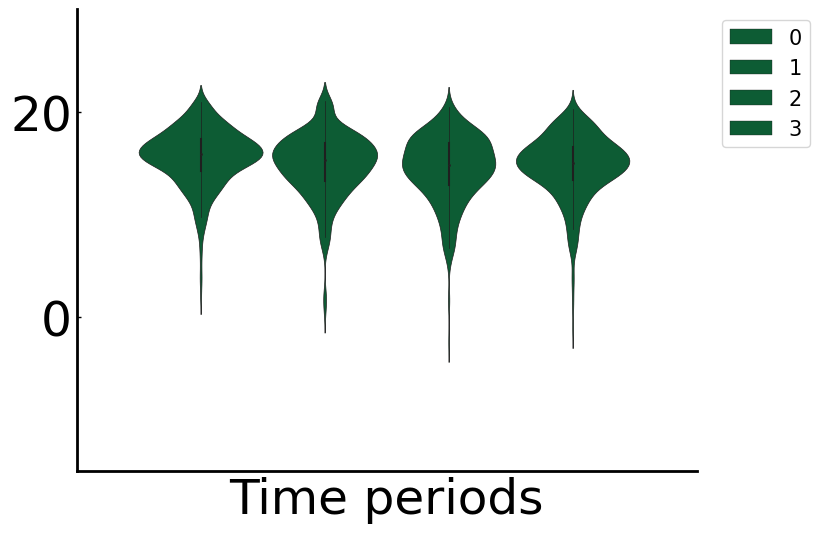

>>>> Testing G7f between different regions
------- G7f S0 vs G7f S1 --------
ks_2samp stat: 0.34782608695652173  p value: 0.12429453839909903
------- G7f S1 vs G7f S2 --------
ks_2samp stat: 0.21739130434782608  p value: 0.6601009653401484
------- G7f S2 vs G7f S3 --------
ks_2samp stat: 0.17391304347826086  p value: 0.8880369085652451
------- G7f S0 vs G7f S3 --------
ks_2samp stat: 0.391304347826087  p value: 0.058268826492191214


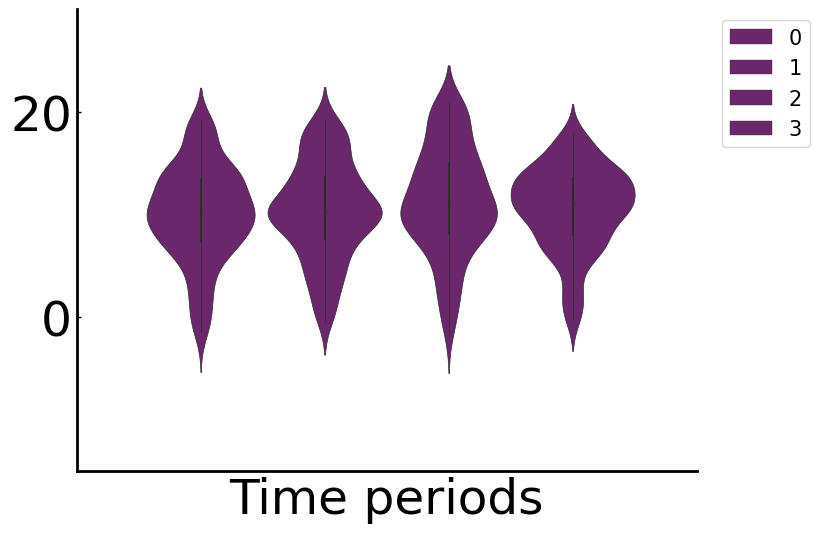

>>>> Testing ACh between different regions
------- ACh S0 vs ACh S1 --------
ks_2samp stat: 0.17391304347826086  p value: 0.8880369085652451
------- ACh S1 vs ACh S2 --------
ks_2samp stat: 0.391304347826087  p value: 0.058268826492191214
------- ACh S2 vs ACh S3 --------
ks_2samp stat: 0.30434782608695654  p value: 0.24057823913888543
------- ACh S0 vs ACh S3 --------
ks_2samp stat: 0.21739130434782608  p value: 0.6601009653401484


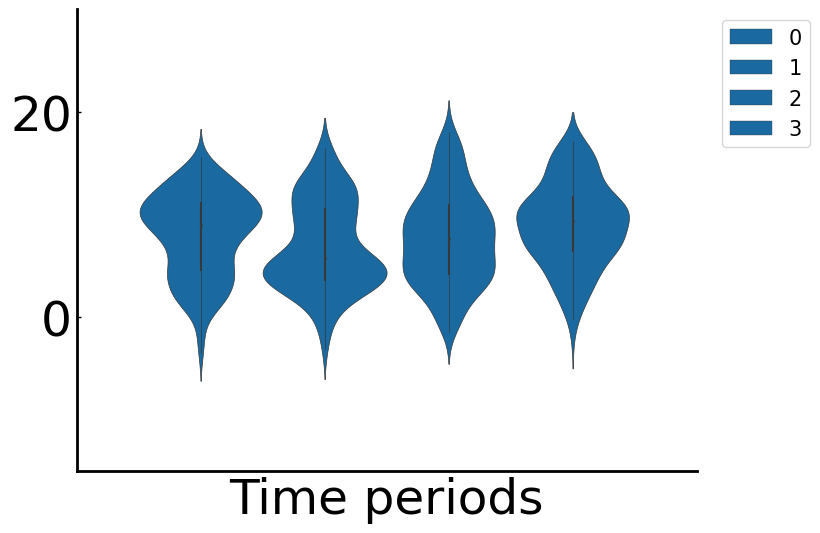

>>>> Testing 5HT between different regions
------- 5HT S0 vs 5HT S1 --------
ks_2samp stat: 0.43478260869565216  p value: 0.02472024578256561
------- 5HT S1 vs 5HT S2 --------
ks_2samp stat: 0.34782608695652173  p value: 0.12429453839909903
------- 5HT S2 vs 5HT S3 --------
ks_2samp stat: 0.5217391304347826  p value: 0.0032406377456433077
------- 5HT S0 vs 5HT S3 --------
ks_2samp stat: 0.21739130434782608  p value: 0.6601009653401484
---- p_g7f:
multi-comparison corrections - pvalue: [0.0621, 0.22, 0.222, 0.0583]
---- p_ach:
multi-comparison corrections - pvalue: [0.222, 0.0583, 0.1203, 0.22]
---- p_5ht:
multi-comparison corrections - pvalue: [0.0124, 0.0414, 0.0032, 0.165]


In [7]:
## parameters
matrics = 12
name = "degree_dist"
    
'''
G7f
'''
calc_path = path_inspur + 'G7f_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for period_i in range(4):
    data_load = pd.read_excel(calc_path + 'whole_brain_network_edges1_stat_ACH_5HT_preiod' + str(period_i) + '.xlsx')
    sti = data_load.iloc[matrics,1]
    calc_all.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    
## load data of each fly
calc_each = []
data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + data_index + '-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## voilin plot
x, data_flatten, hue = [], [], []
for idx in range(4):
    for i in calc_each:
        data_flatten.extend(i[idx])
        x.extend(["Time periods"] * len(i[idx]))
        hue.extend([str(idx)]  * len(i[idx]))
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
ax = sns.violinplot(x = x, y = data_flatten, hue = hue, order=["Time periods"], ax=ax, palette = ['#006934', '#006934', '#006934', '#006934'], 
                 width=0.8, linewidth=0.5, notch=False)
ax.legend(bbox_to_anchor=(0.1,0.1,1.1,0.9), fontsize = 15)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=35,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
ax.set_ylim([-15,30])
plt.savefig(path_local + "period_" + name +"_voilin_calc20.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
p_g7f = []
print(">>>> Testing G7f between different regions")
alternative='two-sided'
mode='auto'
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- G7f S%d vs G7f S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.ks_2samp(calc_all[pair[0]], calc_all[pair[1]], alternative=alternative, mode=mode)
    print("ks_2samp stat:", stat, " p value:", p_vlaue)
    p_g7f.append(p_vlaue)

'''
ACh
'''

calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for period_i in range(4):
    data_load = pd.read_excel(calc_path + 'whole_brain_network_edges1_stat_ACH_preiod' + str(period_i) + '.xlsx')
    sti = data_load.iloc[matrics,1]
    calc_all.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])

## load data of each fly
data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-trans-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## volin plot
x, data_flatten, hue = [], [], []
for idx in range(4):
    for i in calc_each:
        data_flatten.extend(i[idx])
        x.extend(["Time periods"] * len(i[idx]))
        hue.extend([str(idx)]  * len(i[idx]))
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
ax = sns.violinplot(x = x, y = data_flatten, hue = hue, order=["Time periods"], ax=ax, palette = ['#751C77', '#751C77', '#751C77', '#751C77'], 
                 width=0.8, linewidth=0.5, notch=False)
ax.legend(bbox_to_anchor=(0.1,0.1,1.1,0.9), fontsize = 15)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=35,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
ax.set_ylim([-15,30])
plt.savefig(path_local + "period_" + name +"_voilin_ach.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
p_ach = []
print(">>>> Testing ACh between different regions")
alternative='two-sided'
mode='auto'
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- ACh S%d vs ACh S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.ks_2samp(calc_all[pair[0]], calc_all[pair[1]], alternative=alternative, mode=mode)
    print("ks_2samp stat:", stat, " p value:", p_vlaue)
    p_ach.append(p_vlaue)

'''
5HT
'''

calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for period_i in range(4):
    data_load = pd.read_excel(calc_path + 'whole_brain_network_edges1_stat_5HT_preiod' + str(period_i) + '.xlsx')
    sti = data_load.iloc[matrics,1]
    calc_all.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])

## load data of each fly
data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + data_index + '-trans-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## volin plot
x, data_flatten, hue = [], [], []
for idx in range(4):
    for i in calc_each:
        data_flatten.extend(i[idx])
        x.extend(["Time periods"] * len(i[idx]))
        hue.extend([str(idx)]  * len(i[idx]))
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
ax = sns.violinplot(x = x, y = data_flatten, hue = hue, order=["Time periods"], ax=ax, palette = ['#036EB8', '#036EB8', '#036EB8', '#036EB8'], 
                 width=0.8, linewidth=0.5, notch=False)
ax.legend(bbox_to_anchor=(0.1,0.1,1.1,0.9), fontsize = 15)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=35,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.set_axisbelow(True)
ax.set_ylim([-15,30])
plt.savefig(path_local + "period_" + name +"_voilin_5ht.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
p_5ht = []
print(">>>> Testing 5HT between different regions")
alternative='two-sided'
mode='auto'
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- 5HT S%d vs 5HT S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.ks_2samp(calc_all[pair[0]], calc_all[pair[1]], alternative=alternative, mode=mode)
    print("ks_2samp stat:", stat, " p value:", p_vlaue)
    p_5ht.append(p_vlaue)


'''multi-comparison corrections'''

n = 4

print("---- p_g7f:")
ps = [i/n for i in p_g7f]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_ach:")
ps = [i/n for i in p_ach]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_5ht:")
ps = [i/n for i in p_5ht]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

## Figure 5-i

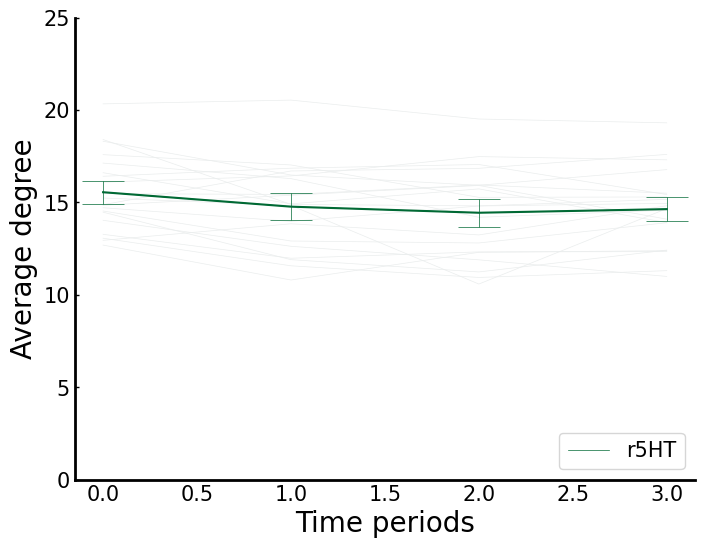

>>>> Testing G7f between different regions
------- G7f S0 vs G7f S1 --------
Wilcoxon stat: 42.0  p value: 0.017181396484375
------- G7f S1 vs G7f S2 --------
Wilcoxon stat: 85.0  p value: 0.47490501403808594
------- G7f S2 vs G7f S3 --------
Wilcoxon stat: 88.0  p value: 0.5458755493164062
------- G7f S0 vs G7f S3 --------
Wilcoxon stat: 44.0  p value: 0.021484375


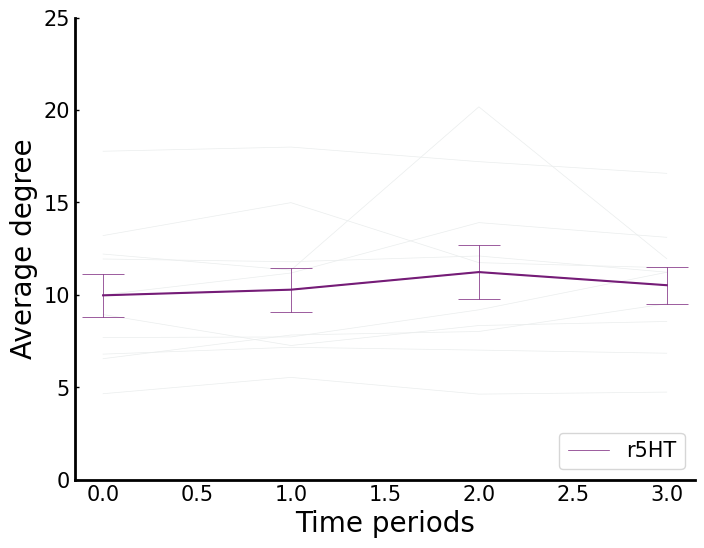

>>>> Testing ACh between different regions
------- ACh S0 vs ACh S1 --------
Wilcoxon stat: 16.0  p value: 0.275390625
------- ACh S1 vs ACh S2 --------
Wilcoxon stat: 19.0  p value: 0.431640625
------- ACh S2 vs ACh S3 --------
Wilcoxon stat: 21.0  p value: 0.556640625
------- ACh S0 vs ACh S3 --------
Wilcoxon stat: 25.0  p value: 0.845703125


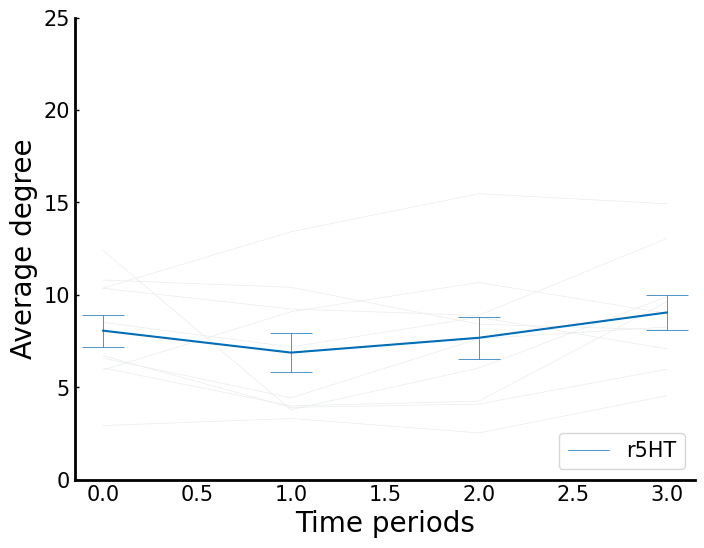

>>>> Testing 5HT between different regions
------- 5HT S0 vs 5HT S1 --------
Wilcoxon stat: 18.0  p value: 0.375
------- 5HT S1 vs 5HT S2 --------
Wilcoxon stat: 14.0  p value: 0.193359375
------- 5HT S2 vs 5HT S3 --------
Wilcoxon stat: 12.0  p value: 0.130859375
------- 5HT S0 vs 5HT S3 --------
Wilcoxon stat: 15.0  p value: 0.232421875
---- p_g7f:
multi-comparison corrections - pvalue: [0.0107, 0.1365, 0.1365, 0.0107]
---- p_ach:
multi-comparison corrections - pvalue: [0.1855, 0.1855, 0.1855, 0.2114]
---- p_5ht:
multi-comparison corrections - pvalue: [0.0938, 0.0775, 0.0775, 0.0775]


In [3]:
## parameters
matrics = 12
name = "degree_dist"
    
'''
G7f
'''
calc_path = path_inspur + 'G7f_average_Stim\\'
nodes = [i for i in range(23)]

## load data of each fly
calc_each = []

data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + data_index + '-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## plot
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
avg_pair_list = []
for i in range(len(avg_list[0])):
    avg_pair_list.append([j[i] for j in avg_list])
avg = []
std = []
for i in range(4):
    avg.append(np.mean(avg_list[i]))
    std.append(np.std(avg_list[i]))
std_yy = np.array(std) / math.sqrt(10)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in avg_pair_list:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#006934', elinewidth = 0.5, color = "#006934", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#006934", label = "r5HT", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
ax.set_ylim([0,25])
plt.ylabel("Average degree", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_" + name +"_avg_calc20.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
    
p_g7f = []
print(">>>> Testing G7f between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- G7f S%d vs G7f S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(avg_list[pair[0]], avg_list[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_g7f.append(p_vlaue)

'''
ACh
'''
calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load data of each fly
data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-trans-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## plot
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
avg_pair_list = []
for i in range(len(avg_list[0])):
    avg_pair_list.append([j[i] for j in avg_list])
avg = []
std = []
for i in range(4):
    avg.append(np.mean(avg_list[i]))
    std.append(np.std(avg_list[i]))
std_yy = np.array(std) / math.sqrt(10)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in avg_pair_list:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#751C77', elinewidth = 0.5, color = "#751C77", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#751C77", label = "r5HT", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
ax.set_ylim([0,25])
plt.ylabel("Average degree", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_" + name +"_avg_ach.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
    
p_ach = []
print(">>>> Testing ACh between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- ACh S%d vs ACh S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(avg_list[pair[0]], avg_list[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_ach.append(p_vlaue)

'''
5HT
'''
calc_path = path_local + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load data of each fly
data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for period_i in range(4):
        ori_path = path_inspur + data_index + '-trans-stimu\\'
        data_load = pd.read_excel(ori_path + 'network_stat\\whole_brain_network_edges1_stat_preiod' + str(period_i) + '.xlsx')
        sti = data_load.iloc[matrics,1]
        each.append([float(i) for i in sti[1:-1].split(', ') if len(i) > 0])
    calc_each.append(each)

## plot
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
avg_pair_list = []
for i in range(len(avg_list[0])):
    avg_pair_list.append([j[i] for j in avg_list])
avg = []
std = []
for i in range(4):
    avg.append(np.mean(avg_list[i]))
    std.append(np.std(avg_list[i]))
std_yy = np.array(std) / math.sqrt(10)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in avg_pair_list:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#036EB8', elinewidth = 0.5, color = "#036EB8", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#036EB8", label = "r5HT", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
plt.ylim(0,25)
plt.ylabel("Average degree", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_" + name +"_avg_5ht.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
avg_list = []
for i in range(4):
    data = [np.mean(group[i]) for group in calc_each]
    avg_list.append(data)
    
p_5ht = []
print(">>>> Testing 5HT between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- 5HT S%d vs 5HT S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(avg_list[pair[0]], avg_list[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_5ht.append(p_vlaue)


'''multi-comparison corrections'''

n = 4

print("---- p_g7f:")
ps = [i/n for i in p_g7f]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_ach:")
ps = [i/n for i in p_ach]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_5ht:")
ps = [i/n for i in p_5ht]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

## Figrue 5-j

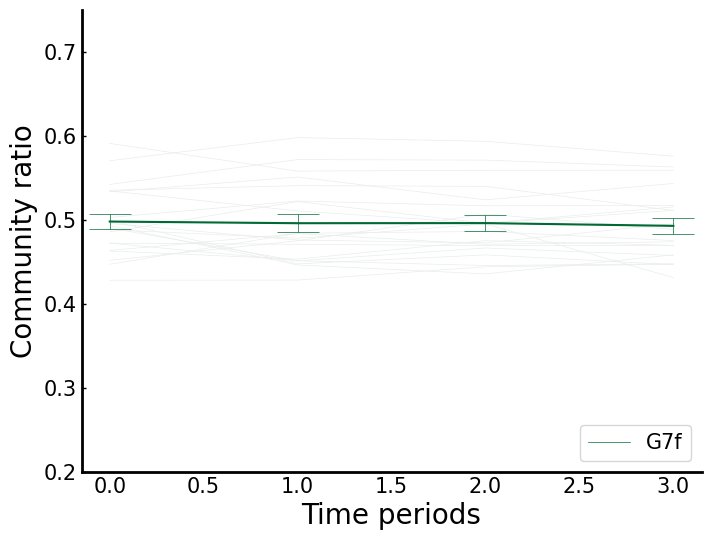

>>>> Testing G7f between different regions
------- G7f S0 vs G7f S1 --------
Wilcoxon stat: 97.0  p value: 0.7841262817382812
------- G7f S1 vs G7f S2 --------
Wilcoxon stat: 101.0  p value: 0.8983173370361328
------- G7f S2 vs G7f S3 --------
Wilcoxon stat: 99.0  p value: 0.8408222198486328
------- G7f S0 vs G7f S3 --------
Wilcoxon stat: 87.0  p value: 0.5216732025146484


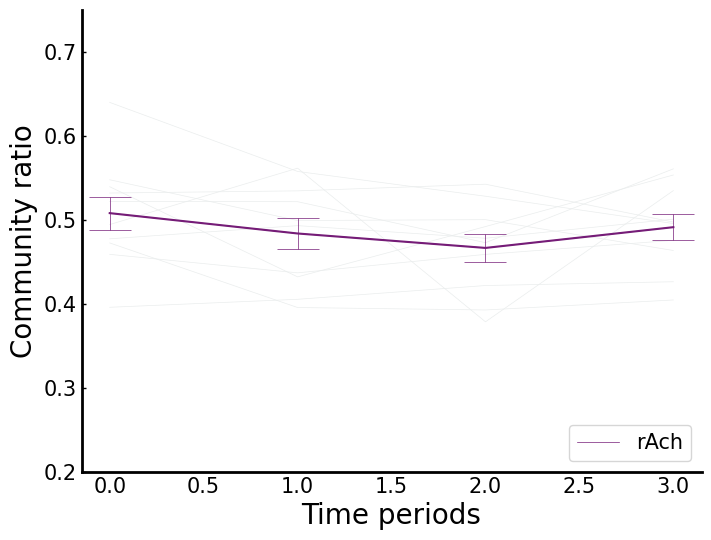

>>>> Testing ACh between different regions
------- ACh S0 vs ACh S1 --------
Wilcoxon stat: 16.0  p value: 0.275390625
------- ACh S1 vs ACh S2 --------
Wilcoxon stat: 24.0  p value: 0.76953125
------- ACh S2 vs ACh S3 --------
Wilcoxon stat: 18.0  p value: 0.375
------- ACh S0 vs ACh S3 --------
Wilcoxon stat: 23.0  p value: 0.6953125


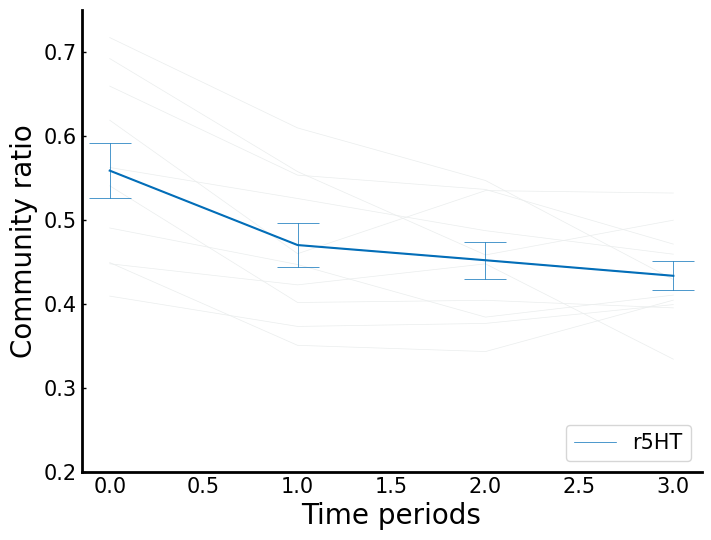

>>>> Testing 5HT between different regions
------- 5HT S0 vs 5HT S1 --------
Wilcoxon stat: 0.0  p value: 0.001953125
------- 5HT S1 vs 5HT S2 --------
Wilcoxon stat: 17.0  p value: 0.322265625
------- 5HT S2 vs 5HT S3 --------
Wilcoxon stat: 20.0  p value: 0.4921875
------- 5HT S0 vs 5HT S3 --------
Wilcoxon stat: 0.0  p value: 0.001953125
---- p_g7f:
multi-comparison corrections - pvalue: [0.2246, 0.2246, 0.2246, 0.2246]
---- p_ach:
multi-comparison corrections - pvalue: [0.1875, 0.1924, 0.1875, 0.1924]
---- p_5ht:
multi-comparison corrections - pvalue: [0.001, 0.1074, 0.123, 0.001]


In [4]:
## the detected community
calc_louvain_comm_main = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14]
ach_louvain_comm_main =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14]
r5ht_louvain_comm_main = [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 14]
 
'''
G7f
'''
calc_path = path_inspur + 'G7f_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for per in range(4):
    data_df = pd.read_csv(calc_path + "whole_brain_network_edges1_ACH_5HT_preiod" + str(per) + ".csv")
    degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
    sum_degree = np.sum(degrees)
    sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main and data_df.iloc[i,1] in calc_louvain_comm_main]
    sum_degree_sub = np.sum(sub_degrees)
    sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main or data_df.iloc[i,1] in calc_louvain_comm_main]
    sum_degree_sub_non = np.sum(sub_degrees_non)
    ratio = sum_degree_sub / sum_degree_sub_non
    calc_all.append(round(ratio,4))

## load data of each fly
calc_each = []
data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
for data_index in data_index_list:
    each = []
    for per in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-stimu\\'
        data_df = pd.read_csv(ori_path + "network\\whole_brain_network_edges1_preiod" + str(per) + ".csv")
        degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
        sum_degree = np.sum(degrees)
        sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main and data_df.iloc[i,1] in calc_louvain_comm_main]
        sum_degree_sub = np.sum(sub_degrees)
        sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main or data_df.iloc[i,1] in calc_louvain_comm_main]
        sum_degree_sub_non = np.sum(sub_degrees_non)
        ratio = sum_degree_sub / sum_degree_sub_non
        each.append(round(ratio,4))
    calc_each.append(each)
data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
for data_index in data_index_list:
    each = []
    for per in range(4):
        ori_path = path_inspur + data_index + '-stimu\\'
        data_df = pd.read_csv(ori_path + "network\\whole_brain_network_edges1_preiod" + str(per) + ".csv")
        degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
        sum_degree = np.sum(degrees)
        sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main and data_df.iloc[i,1] in calc_louvain_comm_main]
        sum_degree_sub = np.sum(sub_degrees)
        sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in calc_louvain_comm_main or data_df.iloc[i,1] in calc_louvain_comm_main]
        sum_degree_sub_non = np.sum(sub_degrees_non)
        ratio = sum_degree_sub / sum_degree_sub_non
        each.append(round(ratio,4))
    calc_each.append(each)

## plot
avg = []
std = []
for i in range(4):
    a = [v[i] for v in calc_each]
    avg.append(np.mean(a))
    std.append(np.std(a))
std_yy = np.array(std) / math.sqrt(20)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in calc_each:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#006934', elinewidth = 0.5, color = "#006934", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#006934", label = "G7f", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
plt.ylim(0.2,0.75)
plt.ylabel("Community ratio", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_comm_ratio_calc20.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
test_data = []
for i in range(4):
    test_data.append([v[i] for v in calc_each])
p_g7f = []
print(">>>> Testing G7f between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- G7f S%d vs G7f S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(test_data[pair[0]], test_data[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_g7f.append(p_vlaue)

'''
ACh
'''
calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for per in range(4):
    data_df = pd.read_csv(calc_path + "whole_brain_network_edges1_ACH_preiod" + str(per) + ".csv")
    degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
    sum_degree = np.sum(degrees)
    sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in ach_louvain_comm_main and data_df.iloc[i,1] in ach_louvain_comm_main]
    sum_degree_sub = np.sum(sub_degrees)
    sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in ach_louvain_comm_main or data_df.iloc[i,1] in ach_louvain_comm_main]
    sum_degree_sub_non = np.sum(sub_degrees_non)
    ratio = sum_degree_sub / sum_degree_sub_non
    calc_all.append(round(ratio,4))
    
## load data of each fly
data_index_list = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', '20230507-fly1', '20230510-fly1',
                       '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for per in range(4):
        ori_path = path_inspur + 'Ach-' + data_index + '-trans-stimu\\'
        data_df = pd.read_csv(ori_path + "network\\whole_brain_network_edges1_preiod" + str(per) + ".csv")
        degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
        sum_degree = np.sum(degrees)
        sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in ach_louvain_comm_main and data_df.iloc[i,1] in ach_louvain_comm_main]
        sum_degree_sub = np.sum(sub_degrees)
        sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in ach_louvain_comm_main or data_df.iloc[i,1] in ach_louvain_comm_main]
        sum_degree_sub_non = np.sum(sub_degrees_non)
        ratio = sum_degree_sub / sum_degree_sub_non
        each.append(round(ratio,4))
    calc_each.append(each)

## plot
avg = []
std = []
for i in range(4):
    a = [v[i] for v in calc_each]
    avg.append(np.mean(a))
    std.append(np.std(a))
std_yy = np.array(std) / math.sqrt(10)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in calc_each:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#751C77', elinewidth = 0.5, color = "#751C77", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#751C77", label = "rAch", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
plt.ylim(0.2,0.75)
plt.ylabel("Community ratio", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_comm_ratio_ach.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
test_data = []
for i in range(4):
    test_data.append([v[i] for v in calc_each])
p_ach = []
print(">>>> Testing ACh between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- ACh S%d vs ACh S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(test_data[pair[0]], test_data[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_ach.append(p_vlaue)

'''
5HT
'''
calc_path = path_inspur + 'ACh_5HT_average_Stim\\'
nodes = [i for i in range(23)]

## load average data
calc_all = []
for per in range(4):
    data_df = pd.read_csv(calc_path + "whole_brain_network_edges1_5HT_preiod" + str(per) + ".csv")
    degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
    sum_degree = np.sum(degrees)
    sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in r5ht_louvain_comm_main and data_df.iloc[i,1] in r5ht_louvain_comm_main]
    sum_degree_sub = np.sum(sub_degrees)
    sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in r5ht_louvain_comm_main or data_df.iloc[i,1] in r5ht_louvain_comm_main]
    sum_degree_sub_non = np.sum(sub_degrees_non)
    ratio = sum_degree_sub / sum_degree_sub_non
    calc_all.append(round(ratio,4))

## load data of each fly
data_index_list = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', 
                   '20230513-r5HT1.0-fly2', '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4',
                   '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']
calc_each = []
for data_index in data_index_list:
    each = []
    for per in range(4):
        ori_path = path_inspur + data_index + '-trans-stimu\\'
        data_df = pd.read_csv(ori_path + "network\\whole_brain_network_edges1_preiod" + str(per) + ".csv")
        degrees = [data_df.iloc[i,2] for i in range(len(data_df))]
        sum_degree = np.sum(degrees)
        sub_degrees = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in r5ht_louvain_comm_main and data_df.iloc[i,1] in r5ht_louvain_comm_main]
        sum_degree_sub = np.sum(sub_degrees)
        sub_degrees_non = [max(data_df.iloc[i,2],0) for i in range(len(data_df)) if data_df.iloc[i,0] in r5ht_louvain_comm_main or data_df.iloc[i,1] in r5ht_louvain_comm_main]
        sum_degree_sub_non = np.sum(sub_degrees_non)
        ratio = sum_degree_sub / sum_degree_sub_non
        each.append(round(ratio,4))
    calc_each.append(each)

## plot
avg = []
std = []
for i in range(4):
    a = [v[i] for v in calc_each]
    avg.append(np.mean(a))
    std.append(np.std(a))
std_yy = np.array(std) / math.sqrt(10)
fig,ax = plt.subplots(figsize=(8,6),dpi=100,facecolor="w")
for i in calc_each:
    plt.plot(i, color = "#EAEDED", linewidth = 0.5)
plt.errorbar(list(range(4)), avg, yerr = std_yy, fmt = '', ecolor = '#036EB8', elinewidth = 0.5, color = "#036EB8", capsize = 15, capthick = 0.5)
plt.plot(avg, color = "#036EB8", label = "r5HT", linewidth = 0.5)
ax.tick_params(which='major',direction='in',length=3,width=1.,labelsize=15,bottom=False)
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.set_axisbelow(True)
plt.legend(loc = 4, fontsize = 15)
plt.ylim(0.2,0.75)
plt.ylabel("Community ratio", fontsize = 20)
plt.xlabel("Time periods", fontsize = 20)
plt.savefig(path_local + "period_comm_ratio_5ht.pdf", dpi = 300, bbox_inches='tight')
plt.show()

## test
test_data = []
for i in range(4):
    test_data.append([v[i] for v in calc_each])
p_5ht = []
print(">>>> Testing 5HT between different regions")
for pair in [(0,1), (1,2), (2,3), (0,3)]:
    print("------- 5HT S%d vs 5HT S%d --------" % (pair[0], pair[1]))
    stat, p_vlaue = stats.wilcoxon(test_data[pair[0]], test_data[pair[1]], alternative='two-sided', correction = True)
    print("Wilcoxon stat:", stat, " p value:", p_vlaue)
    p_5ht.append(p_vlaue)
    

'''multi-comparison corrections'''

n = 4

print("---- p_g7f:")
ps = [i/n for i in p_g7f]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_ach:")
ps = [i/n for i in p_ach]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])

print("---- p_5ht:")
ps = [i/n for i in p_5ht]
rej, ps_adj, _, _ = multipletests(ps, method = 'fdr_bh')
print("multi-comparison corrections - pvalue:", [round(i,4) for i in ps_adj])